#   MASTER
## Welcome to mat2py tool. This applies SH to process GRACE SH coefficients into Terrestrial water storage changes
#### Kindly provide the paths to respective files and outputs
#### 1. Reading SH coeffs from NASA JPL and replacing degree 1,2,3 coeffs'

In [ ]:
path_sh = r"/home/wslvivek/Desktop/level2/pysh_v2/JPL_input/"                      # Path to JPL GRACE data
path_tn14 = r"/home/wslvivek/Desktop/level2/pysh_v2/JPL_TN_files/TN-14_C30_C20_GSFC_SLR.txt"    # Path to TN14
path_tn13 = r"/home/wslvivek/Desktop/level2/pysh_v2/JPL_TN_files/TN-13_GEOC_JPL_RL06.txt"       # Path to TN13

In [ ]:
source=str(input("Enter the source of L2 SH coeffs code(jpl, csr, itsg): "))

In [ ]:
import os
path_master = os.getcwd()                                            # current directory
path_functions = os.path.join(path_master,"pysh_funcs")        # directory of the sh bundle functions
path_output = os.path.join(os.path.dirname(path_master),"output")    # directory for output
path_matlab_input = os.path.join(os.path.dirname(path_master),"validation/input_for_matlab")# directory for raw-sc coeffs

In [ ]:
from reader_replacer_jpl import reader_replacer_jpl
from reader_replacer_csr import reader_replacer_csr
from reader_replacer_itsg import reader_replacer_itsg
from klm2sc import klm2sc
from clm2sc import clm2sc
from scrpit import tws_cal
from basin_avg import basin_avg
import numpy as np
import pandas as pd
import xarray as xr
import warnings
warnings.filterwarnings('ignore')

In [ ]:
%%time
if source == 'jpl':
    sh_clm, dates_start, dates_end, no_of_files = reader_replacer_jpl(path_sh, path_tn14, path_tn13)
elif source == 'csr':
    sh_clm, dates_start, dates_end, no_of_files = reader_replacer_csr(path_sh, path_tn14, path_tn13)
elif source=='itsg':
    sh_clm, dates_start, no_of_files = reader_replacer_itsg(path_sh, path_tn14, path_tn13)

* `sh_clm` is a ndarray containg lists of data: degree;  order; clm; slm; delta clm; delta slm; start data; end date*

#### 2. The following cells perform a bunch of operations


* Storing SH coeffs in clm format into SC format
* Calculation of delta clm & delta slm
* Application of Gaussian filter/filter of user choice
* Application of filter to delta clm, slm to get filtered SH coeffs
* Calling gshs() with filtered SH coeffs to obtain TWS fields
* Flipping the TWS fields to get 0 degree longitude in the middle
* Saving data in netCDF4 format and writing to disk

In [ ]:
if source == 'jpl':
    raw_sc = clm2sc(sh_clm);
elif source == 'csr':
    raw_sc = klm2sc(sh_clm);
elif source== 'itsg':
    raw_sc = clm2sc(sh_clm);

In [ ]:
# np.save(path_matlab_input+'/raw_sc_'+source,raw_sc)
raw_sc = clm2sc(sh_clm);
import scipy.io
scipy.io.savemat('/home/wslvivek/Desktop/level2/pysh_v2/validation/input_for_matlab/raw_sc_'+source+'.mat', {"raw_sc": raw_sc})

In [ ]:
lmax = 96
gs = 1
half_rad_gf = 500

In [ ]:
lon = np.arange(-180,180,gs)
lat = np.arange(89,-91,-gs)
# dates = pd.to_datetime(pd.Series(dates_start), format='%Y-%m-%d').dt.strftime('%d-%m-%Y') \
#         + "    " \
#         +pd.to_datetime(pd.Series(dates_end), format='%Y-%m-%d').dt.strftime('%d-%m-%Y')
dates = pd.to_datetime(pd.Series(dates_start), format='%Y-%m-%d')#.dt.strftime('%d-%m-%Y')
print('dates read! \n')
dates.to_csv(path_output+'/dates_'+source+'.csv')

##### Remove long term mean to get anomalies
* Long term mean is calculated from NASA JPL SH coeffs in the period 01-01-2005 & 31-12-2010 (6 years continuous)

In [ ]:
SH_long_mean_jpl = np.load(path_master+'/long_mean/SH_long_mean_jpl.npy')    # load the long term mean SH coeffs---> JPL 
SH_long_mean_csr = np.load(path_master+'/long_mean/SH_long_mean_csr.npy')    # load the long term mean SH coeffs---> CSR
SH_long_mean_itsg = np.load(path_master+'/long_mean/SH_long_mean_itsg.npy')    # load the long term mean SH coeffs---> ITSG
if source== 'jpl':
    delta_sc = raw_sc - SH_long_mean_jpl
elif source== 'csr':
    delta_sc = raw_sc - SH_long_mean_csr
elif source== 'itsg':
    delta_sc = raw_sc - SH_long_mean_itsg

In [ ]:
%%time
tws_fields = tws_cal(delta_sc,lmax,gs,half_rad_gf,no_of_files,path_functions)
tws_fields = np.float32(tws_fields)

In [ ]:
ds = xr.Dataset(
    data_vars=dict(
        tws=(["time","lat", "lon"], tws_fields)
    ),
    coords = {
        "time":(('time'),dates),
        "lat":lat,
        "lon":lon },
    attrs=dict(description="TWS Anomaly corresponding to long term (2004-2010) mean \n lmax=96 and half radius of Gaussian filter = 500Km"),
)
ds

In [ ]:
ds.tws.isel(time=-1).plot()

In [ ]:
ds.to_netcdf(path_output+'/'+'tws_py_'+source+'.nc', engine="netcdf4")

## Basin average

In [ ]:
ans = str(input('Do you want to calculate basin average?(y/n):'))
if ans == 'y':
    path_shapefile = r"/home/wslvivek/Desktop/garca/vivek/Ganga.shp"
    c_rs = str(input('Enter projected reference system:'))
    tws_basin_avg = basin_avg(ds,path_shapefile,c_rs,no_of_files,gs)
else:
    pass

In [ ]:
tws_basin_avg.to_netcdf(path_output+'/tws_basin_avg.nc', engine="netcdf4")

#

## Validation of `pyshbundle` with `shbundle` generated TWS

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import warnings
import matplotlib.pyplot as plt

In [2]:
''' Load tws processed data from shbundle as .mat file & from pyshbundle as xarray dataset '''
import scipy.io
# Load the .mat file
data = scipy.io.loadmat('/home/wslvivek/Desktop/level2/pysh_v2/output/tws_m_jpl.mat')
# Access the variables in the .mat file
var1 = data['tws_m']

temp=xr.open_dataset('/home/wslvivek/Desktop/level2/pysh_v2/output/tws_py_jpl.nc', engine="netcdf4")
var2=temp.tws.values

In [3]:
''' Area weighting '''
# Calculation of area of each corresponding to  the latitudes and longitudes
deg = 1;
x = np.linspace(0, 359+(1-deg), int(360/deg), dtype='double');
y = np.linspace(0, 179+(1-deg), int(180/deg), dtype='double');
x1 = np.linspace(1*deg, 360, int(360/deg), dtype='double');
y1 = np.linspace(1*deg, 180, int(180/deg), dtype='double');
lambd,theta = np.meshgrid(x,y)  
lambd1,theta1 = np.meshgrid(x1,y1)  
a = np.sin(np.deg2rad(90-theta))-np.sin(np.deg2rad(90-theta1))
b = (lambd1 - lambd)*np.pi/180


# Area of each grid (360*720)
area = (6378.137**2)*pow(10,6)*(np.multiply(a,b))        # units m^2

var1_=np.zeros(var1.shape)
var2_=np.zeros(var2.shape)
for i in range(0,var1.shape[0],1):
    var1_[i,:,:] = np.multiply(var1[i,:,:],area)
    var2_[i,:,:] = np.multiply(var2[i,:,:],area)

In [4]:
''' Write data to netcdf files to clip using geopandas '''
gs=1;
lon = np.arange(-180,180,gs)
lat = np.arange(89,-91,-gs)
tws_py_jpl = xr.Dataset(
    data_vars=dict(
        tws=(["time","lat", "lon"], var2_)
    ),
    coords = {
        "time":(('time'),temp.time.data),
        "lat":lat,
        "lon":lon },
    attrs=dict(description="TWS Anomaly corresponding to long term (2004-2010) mean \n lmax=96 and half radius of Gaussian filter = 500Km"),
)

dates_m=pd.read_csv('/home/wslvivek/Desktop/level2/pysh_v2/output/dates_jpl.csv').iloc[:,1] # dates of solution obtainesd from the output foler of master
tws_m_jpl = xr.Dataset(
    data_vars=dict(
        tws=(["time","lat", "lon"], var1_)
    ),
    coords = {
        "time":(('time'),dates_m),
        "lat":lat,
        "lon":lon },
    attrs=dict(description="TWS Anomaly corresponding to long term (2004-2010) mean \n lmax=96 and half radius of Gaussian filter = 500Km"),
)
tws_py_jpl, tws_m_jpl

(<xarray.Dataset>
 Dimensions:  (time: 201, lat: 180, lon: 360)
 Coordinates:
   * time     (time) datetime64[ns] 2002-04-04 2002-05-02 ... 2022-06-01
   * lat      (lat) int64 89 88 87 86 85 84 83 82 ... -84 -85 -86 -87 -88 -89 -90
   * lon      (lon) int64 -180 -179 -178 -177 -176 -175 ... 175 176 177 178 179
 Data variables:
     tws      (time, lat, lon) float64 -2.81e+08 -2.757e+08 ... 1.347e+10
 Attributes:
     description:  TWS Anomaly corresponding to long term (2004-2010) mean \n ...,
 <xarray.Dataset>
 Dimensions:  (time: 201, lat: 180, lon: 360)
 Coordinates:
   * time     (time) object '2002-04-04' '2002-05-02' ... '2022-06-01'
   * lat      (lat) int64 89 88 87 86 85 84 83 82 ... -84 -85 -86 -87 -88 -89 -90
   * lon      (lon) int64 -180 -179 -178 -177 -176 -175 ... 175 176 177 178 179
 Data variables:
     tws      (time, lat, lon) float64 -2.81e+08 -2.757e+08 ... 1.347e+10
 Attributes:
     description:  TWS Anomaly corresponding to long term (2004-2010) mean \n ...)

### `Spatial RMSE calculation`

In [5]:
diff = var1 - var2
squared_diff=diff**2
mean_squared_diff=np.mean(squared_diff, axis=0)
rmse=np.sqrt(mean_squared_diff)
nrmse=rmse/np.std(var1, axis=0)
std_=np.std(var1, axis=0)

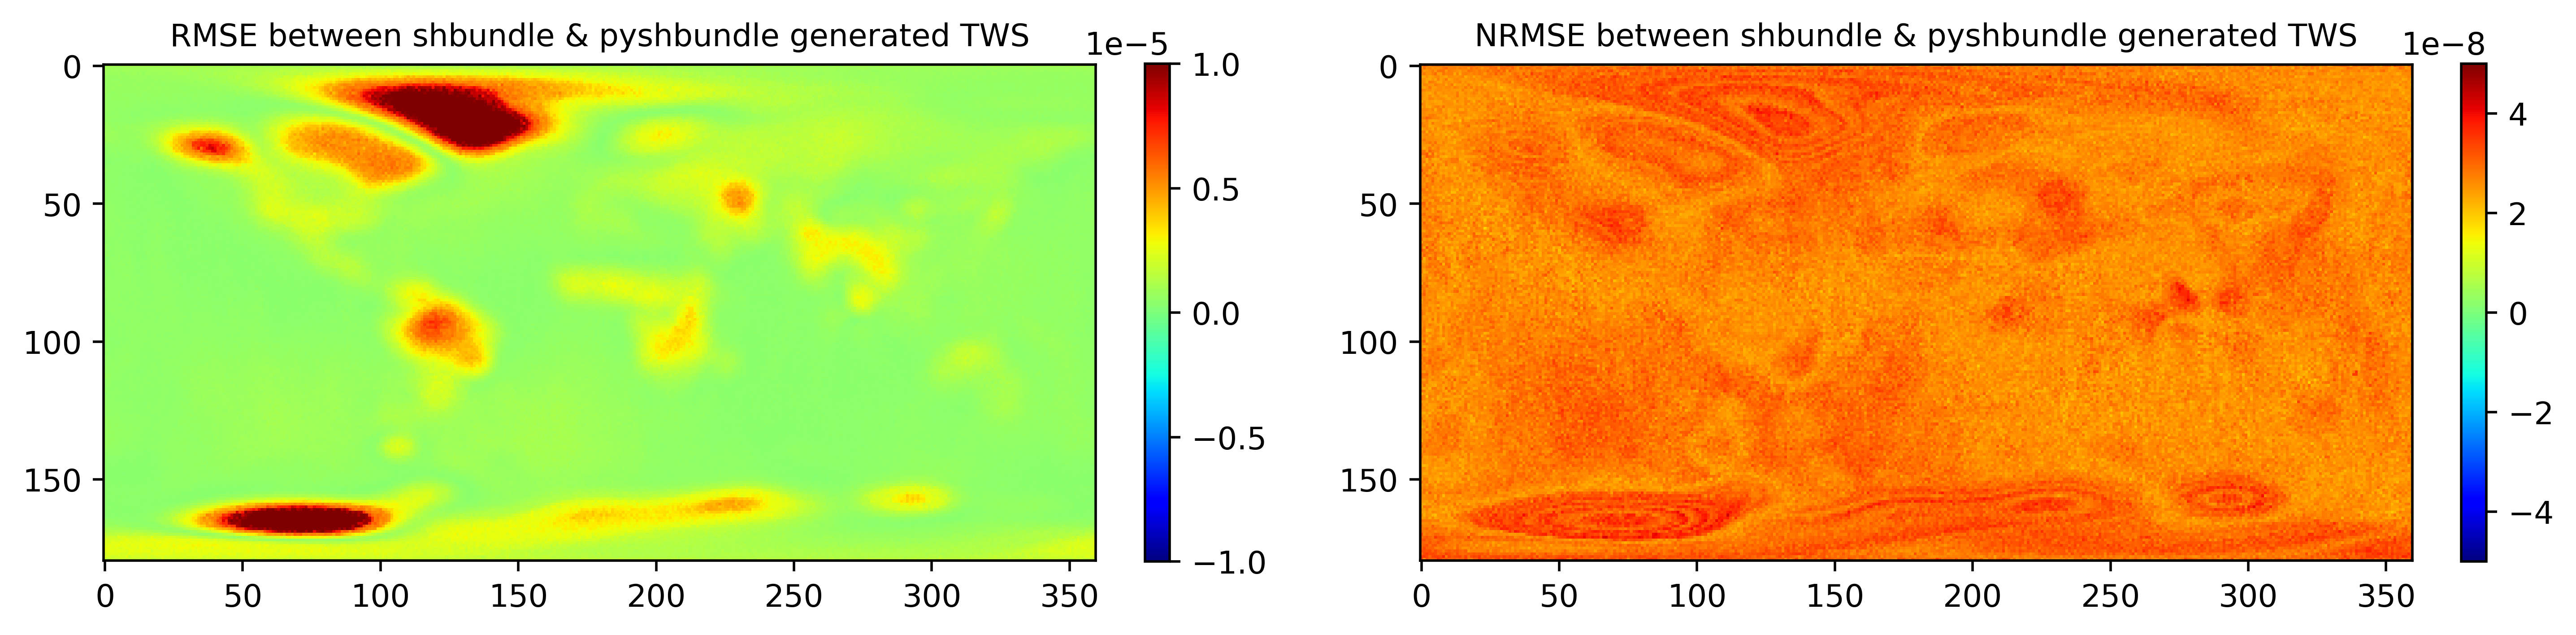

In [6]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,4), dpi=500)

im1=ax1.imshow(rmse, cmap='jet', vmin=-1e-5, vmax=1e-5)
cbar2 = fig.colorbar(im1, ax=ax1, pad=0.04, shrink=0.6)
ax1.set_title('RMSE between shbundle & pyshbundle generated TWS',fontsize=10)
im2=ax2.imshow(nrmse, cmap='jet', vmin=-0.5*1e-7, vmax=0.5*1e-7)
cbar2 = fig.colorbar(im2, ax=ax2, pad=0.04, shrink=0.6)
ax2.set_title('NRMSE between shbundle & pyshbundle generated TWS',fontsize=10)
plt.subplots_adjust(top=0.9, bottom=0.1)
fig.tight_layout()
plt.savefig('/home/wslvivek/Desktop/level2/pysh_v2/validation/error_plots.png')
plt.show()

### `Basin avg RMSE`

In [7]:
import geopandas as gpd
import rioxarray
from shapely.geometry import mapping

<AxesSubplot:>

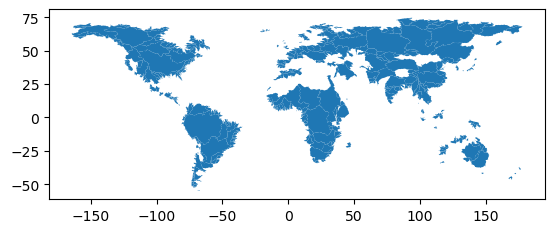

In [8]:
# import shapefile
path='/home/wslvivek/Desktop/level2/pysh_v2/validation/shapefiles/mrb_shp_zip/mrb_basins.shp'
# path='/home/wslvivek/Desktop/level2/pysh_v2/validation/shapefiles/hybas_as_lev01-12_v1c/hybas_as_lev04_v1c.shp'
shp = gpd.read_file(path)
shp.plot()

In [9]:
shp.head()

,MRBID,RIVER_BASI,CONTINENT,SEA,OCEAN,SUM_SUB_AR,Shape_Leng,Shape_Area,geometry
0,1201,ATOUI,Africa,North Atlantic,Atlantic Ocean,27695.4,11.874010,2.409224,"POLYGON ((-13.71723 22.88554, -13.71667 22.879..."
1,1202,BANDAMA,Africa,Gulf of Guinea,Atlantic Ocean,99254.1,18.506812,8.107313,"POLYGON ((-5.37917 6.21250, -5.38034 6.21708, ..."
2,1203,BIA,Africa,Gulf of Guinea,Atlantic Ocean,10957.1,7.141522,0.891547,"POLYGON ((-2.69497 7.34616, -2.68797 7.34105, ..."
3,1204,CAVALLY,Africa,Gulf of Guinea,Atlantic Ocean,29622.9,13.092576,2.408952,"POLYGON ((-8.26748 7.93681, -8.26605 7.92701, ..."
4,1205,CESTOS (also NUON),Africa,North Atlantic,Atlantic Ocean,12785.0,8.018670,1.040702,"POLYGON ((-8.38159 7.58785, -8.36667 7.58750, ..."


In [19]:
shp['RIVER_BASI']

0                   ATOUI
1                 BANDAMA
2                     BIA
3                 CAVALLY
4      CESTOS (also NUON)
              ...        
515                VARDAR
516               VISTULA
517                 WESER
518                  KURA
519                 VOLGA
Name: RIVER_BASI, Length: 520, dtype: object

     MRBID              RIVER_BASI      CONTINENT             SEA  \
186   3203  AMAZON (also AMAZONAS)  South America  North Atlantic   

              OCEAN  SUM_SUB_AR  Shape_Leng  Shape_Area  \
186  Atlantic Ocean   5965893.5  167.089927  488.059318   

                                              geometry  
186  POLYGON ((-50.71667 -1.77083, -50.72124 -1.772...  


<AxesSubplot:>

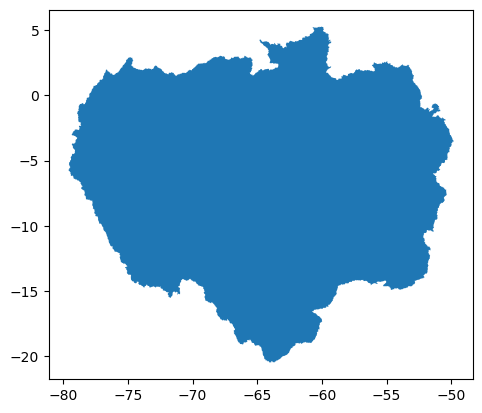

In [15]:
# select ganga shapefile: HYBAS_ID = 4040960480
shp_g=shp[shp['RIVER_BASI']=='AMAZON (also AMAZONAS)']
# shp_g=shp[shp['HYBAS_ID']==4040960480] AMAZON (also AMAZONAS) GANGES
print(shp_g)
shp_g.plot()

In [16]:
# clip data using shapefile
''' add projection system to nc '''
basin_tws_py_jpl_ = tws_py_jpl.rio.write_crs("EPSG:4326", inplace=True)
basin_tws_py_jpl_ = basin_tws_py_jpl_.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
basin_tws_m_jpl_ = tws_m_jpl.rio.write_crs("EPSG:4326", inplace=True)
basin_tws_m_jpl_ = basin_tws_m_jpl_.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
        
# mask data with shapefile
basin_tws_py_jpl = basin_tws_py_jpl_.rio.clip(shp_g.geometry.apply(mapping), shp_g.crs,drop=False)
basin_tws_m_jpl = basin_tws_m_jpl_.rio.clip(shp_g.geometry.apply(mapping), shp_g.crs,drop=False)

# basin_area=np.float64(shp_g['SUB_AREA'])*1e6
basin_area=np.float64(shp_g['Shape_Area'])*1e10

basin_avg_tws_py_jpl=basin_tws_py_jpl.tws.sum(dim=('lon','lat'))/basin_area
basin_avg_tws_m_jpl=basin_tws_m_jpl.tws.sum(dim=('lon','lat'))/basin_area
diff_basin_avg_tws=basin_avg_tws_m_jpl.data-basin_avg_tws_py_jpl.data

In [17]:
import matplotlib.pyplot as plt

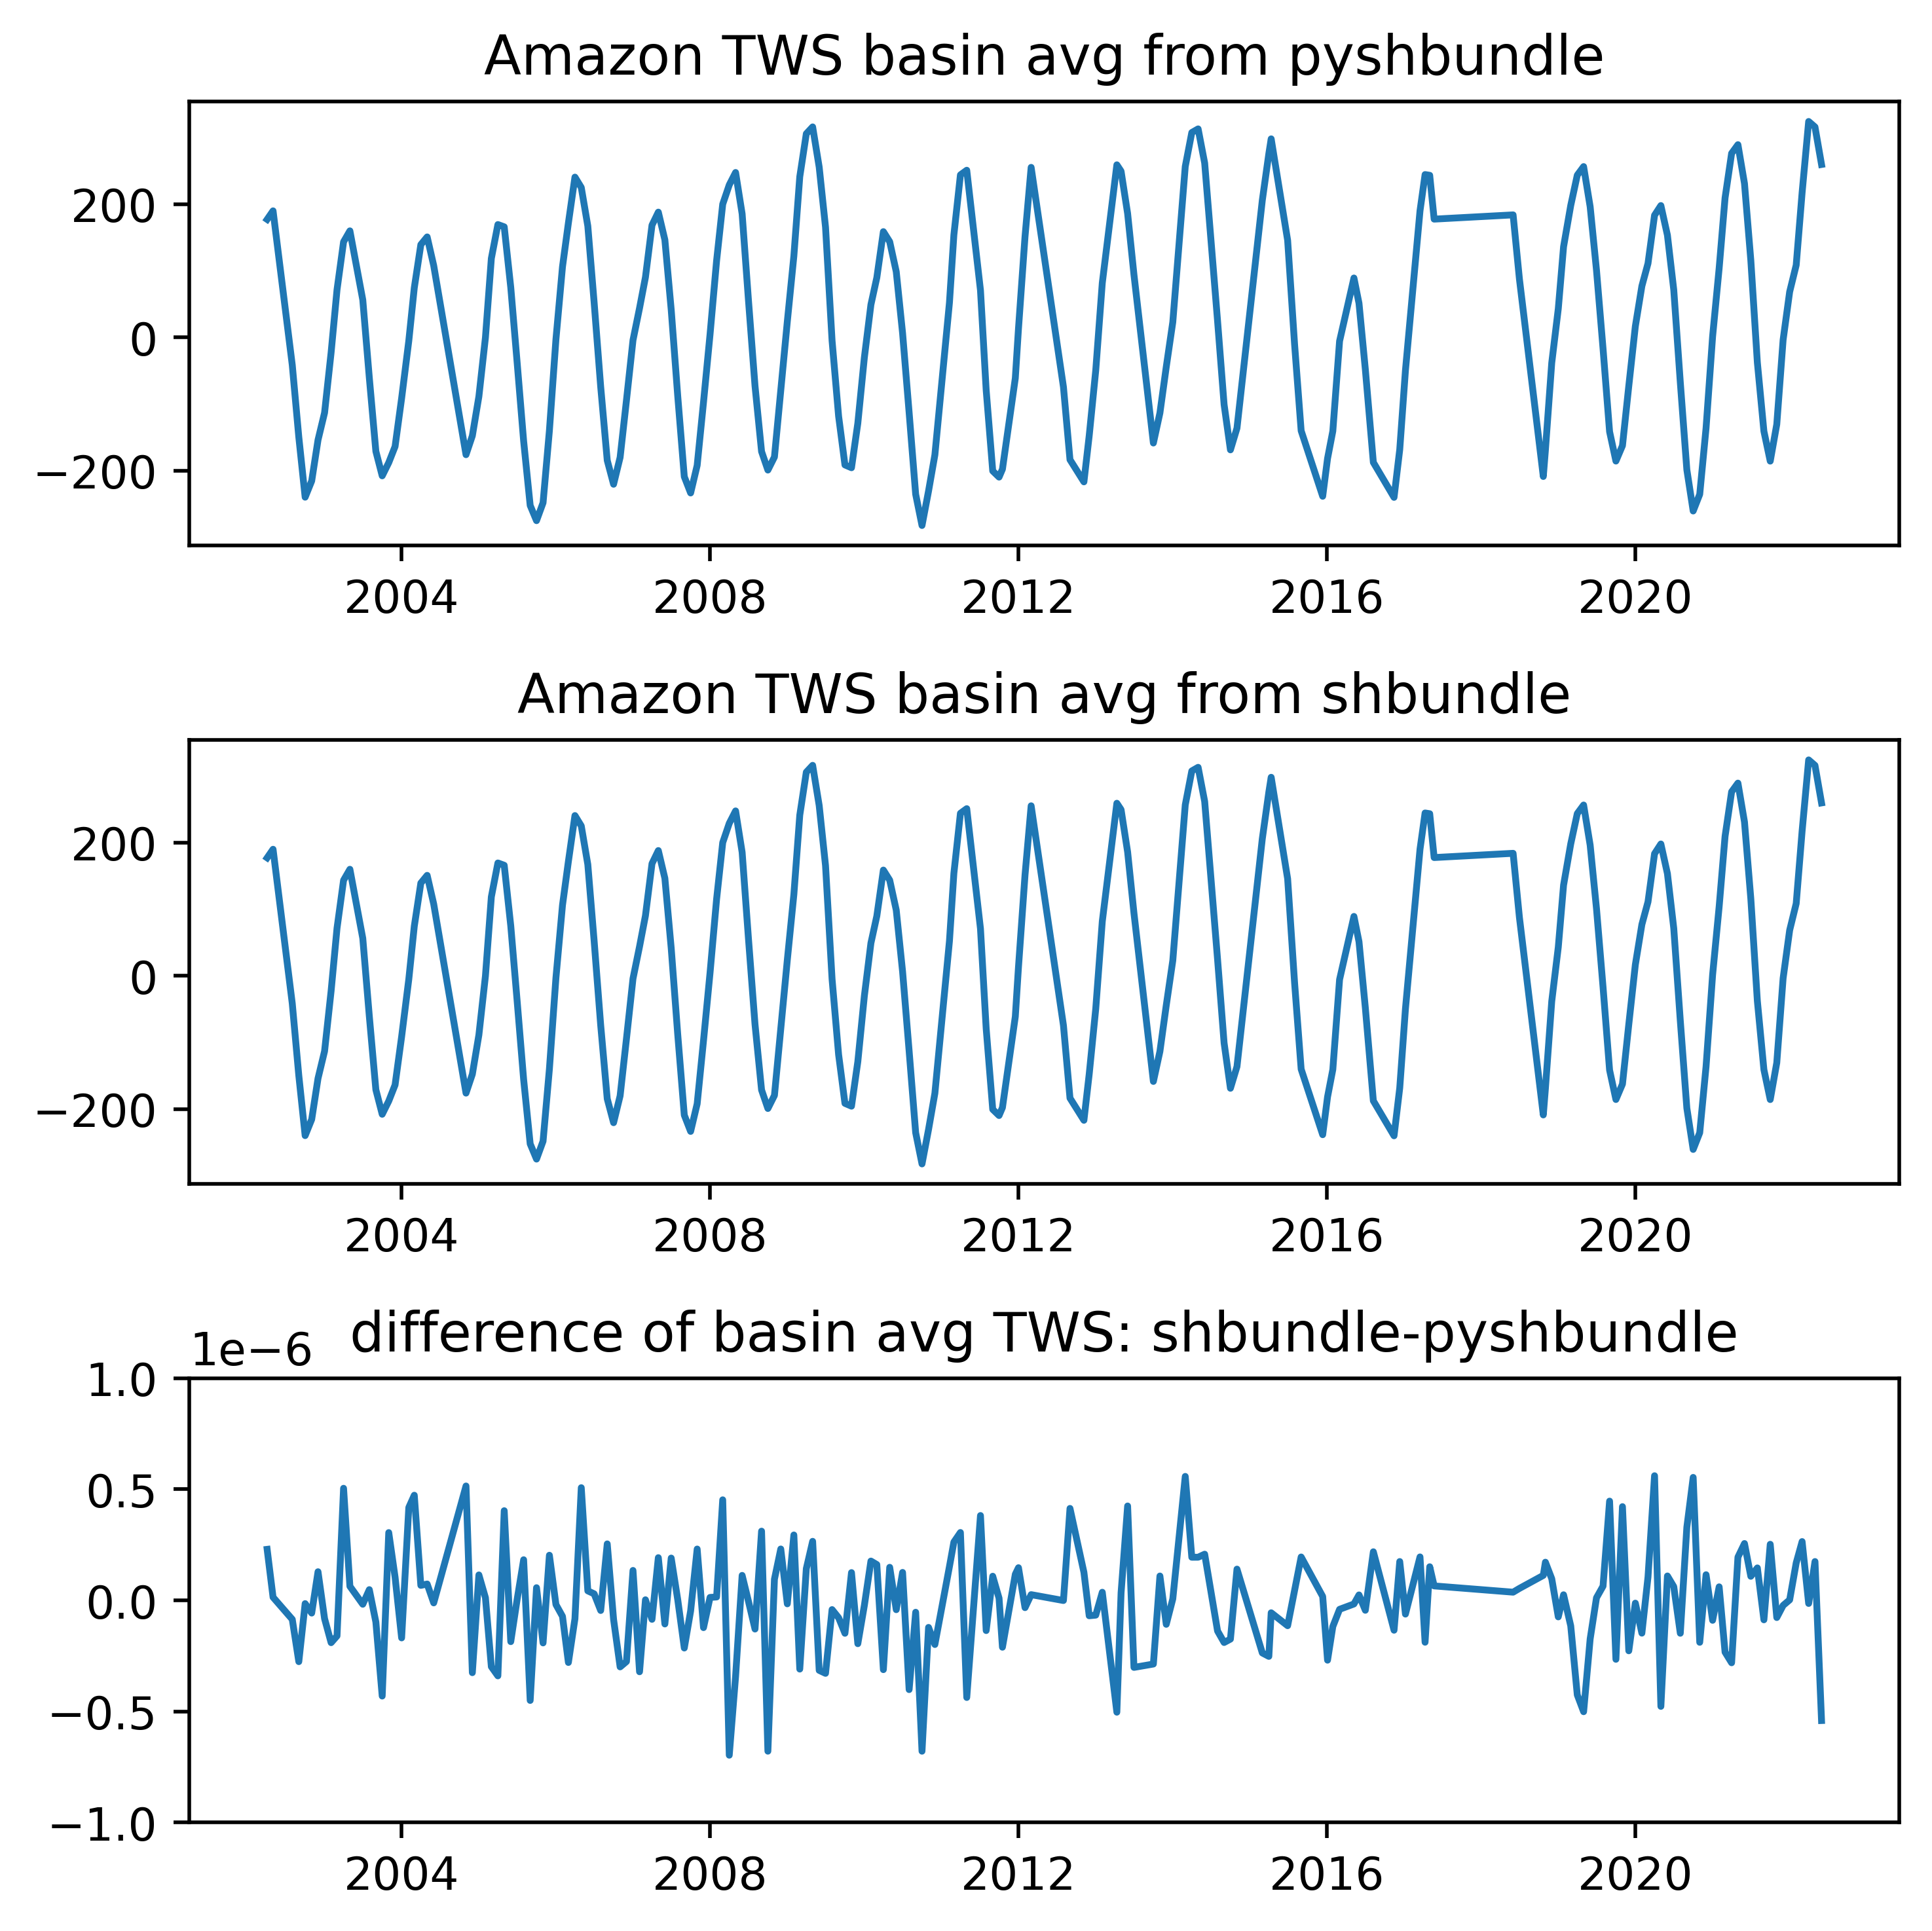

In [18]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(6, 6), dpi=500)
axes[0].plot(basin_avg_tws_py_jpl.time, basin_avg_tws_py_jpl)
axes[0].set_title('Amazon TWS basin avg from pyshbundle')
axes[1].plot(basin_avg_tws_py_jpl.time, basin_avg_tws_m_jpl)
axes[1].set_title('Amazon TWS basin avg from shbundle')
axes[2].plot(basin_avg_tws_py_jpl.time, diff_basin_avg_tws.data)
axes[2].set_title('difference of basin avg TWS: shbundle-pyshbundle')
plt.ylim(-1e-6,1e-6)
fig.tight_layout()
plt.savefig('/home/wslvivek/Desktop/level2/pysh_v2/validation/basin_avg_error_Amazon.png')